In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report,f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
x_train = pd.read_csv('data_source/X_train.csv')
y_train = pd.read_csv('data_source/y_train.csv')

x_test = pd.read_csv('data_source/X_test.csv')
y_test = pd.read_csv('data_source/y_test.csv')


x_train_robust = x_train.copy()
y_train_robust = y_train.copy()

x_test_robust = x_test.copy()
y_test_robust = y_test.copy()


x_train_robust = x_train_robust.loc[:,['Destination Port', 'NAT Source Port','Packets', 'Elapsed Time (sec)','Bytes Received','NAT Destination Port']]
y_train_robust = y_train_robust.loc[:,'Action']
x_test_robust = x_test_robust.loc[:,['Destination Port', 'NAT Source Port','Packets', 'Elapsed Time (sec)','Bytes Received','NAT Destination Port']]
y_test_robust = y_test_robust.loc[:,'Action']

In [17]:
robust = RobustScaler()

x_train_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']] = robust.fit_transform(x_train_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']])
x_test_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']] = robust.fit_transform(x_test_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']])

/var/folders/v5/n7zzf9t13vn15ppbmryx4bdr0000gn/T/ipykernel_88199/2635941453.py:3: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x_train_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']] = robust.fit_transform(x_train_robust.loc[:,['Packets','Elapsed Time (sec)','Bytes Received']])


In [18]:
pipe = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', KNeighborsClassifier()) # object='multi:softmax',num_class=4,seed=42,eval_metric='merror'
])

In [19]:
parameters = [{'classifier__n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],'classifier__weights':['uniform', 'distance'],'classifier__algorithm':['auto', 'ball_tree']},
]

In [20]:
grid = GridSearchCV(pipe,parameters,cv=5,scoring='f1_macro',n_jobs=-1)
grid.fit(x_train_robust, y_train_robust)
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Best parameter (CV score=0.968):
{'classifier__algorithm': 'auto', 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform'}
Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier', KNeighborsClassifier())])


In [21]:
pipe.set_params(classifier__algorithm='auto', classifier__n_neighbors = 5, classifier__weights = 'uniform')

Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier', KNeighborsClassifier())])

In [22]:
train_sizes, train_scores, test_scores = learning_curve(pipe, x_train_robust, y_train_robust, cv=5,scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/var/folders/v5/n7zzf9t13vn15ppbmryx4bdr0000gn/T/ipykernel_88199/3392221839.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='b', linestyle='-')


Text(0.5, 1.0, 'KNN Learning Curve')

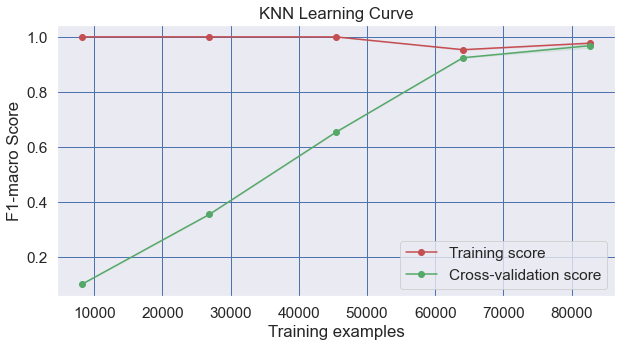

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
plt.xlabel("Training examples")
plt.ylabel("F1-macro Score")

plt.grid(b=True, which='major', color='b', linestyle='-')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")
plt.title('KNN Learning Curve')

In [24]:
pipe.fit(x_train_robust, y_train_robust)

print('Training set score: ' + str(pipe.score(x_train_robust,y_train_robust)))
print('Test set score: ' + str(pipe.score(x_test_robust,y_test_robust)))

Training set score: 0.9776726090238662
Test set score: 0.9033570701932858


Final - Test Model

In [25]:
pipe.fit(x_train_robust, y_train_robust)

train_yhat = pipe.predict(x_train_robust)
train_pipe = f1_score(train_yhat,y_train_robust,average='macro')

test_yhat = pipe.predict(x_test_robust)
test_pipe = f1_score(test_yhat,y_test_robust,average='macro')
print('Train Score\n',classification_report(y_train_robust,train_yhat))
print('Test Score\n',classification_report(y_test_robust, test_yhat))
print(f"AVG F1-Score Train: {train_pipe}\nAVG F1-Score Test: {test_pipe}")

Train Score
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26036
           1       0.96      0.95      0.95     25387
           2       1.00      1.00      1.00     26234
           3       0.95      0.96      0.96     25669

    accuracy                           0.98    103326
   macro avg       0.98      0.98      0.98    103326
weighted avg       0.98      0.98      0.98    103326

Test Score
               precision    recall  f1-score   support

           0       1.00      0.84      0.92     11292
           1       0.98      0.97      0.97      4496
           2       1.00      1.00      1.00      3856
           3       0.01      0.94      0.02        16

    accuracy                           0.90     19660
   macro avg       0.75      0.94      0.73     19660
weighted avg       0.99      0.90      0.94     19660

AVG F1-Score Train: 0.9774053846787893
AVG F1-Score Test: 0.7259071127913006


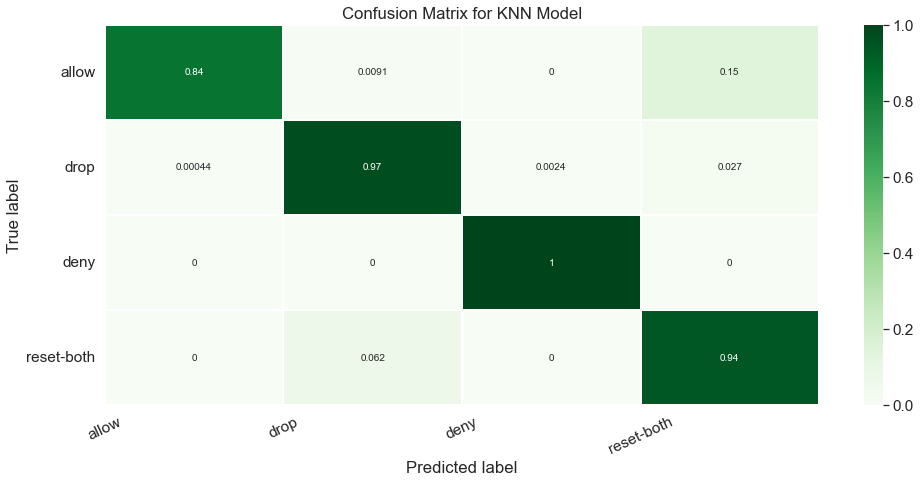

In [37]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, test_yhat)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['allow','drop','deny','reset-both']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for KNN Model')
plt.show()
